In [12]:
!git clone https://stefan-matcovici/language-detection.git
!pip install -r language-detection/requirements.txt

fatal: destination path 'language-detection' already exists and is not an empty directory.
Already on 'cookiecutter'
Your branch is up to date with 'origin/cookiecutter'.


In [13]:
import sys
sys.path.append('/content/language-detection/src')

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from data.willi2018 import Wili2018Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, plot_confusion_matrix, classification_report
from sklearn.metrics import classification_report, confusion_matrix
from pprint import pprint

from tqdm.auto import tqdm
from time import time
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

###Dataset download and loading

In [16]:
# !cd language-detection; chmod u+x scripts/download_wili2018.sh; ./scripts/download_wili2018.sh

In [17]:
target_languages = ['eng', 'rus', 'fra', 'spa', 'deu', 'ita', 'nld', 'jpn', 'ara', 'hin', 'urd', 'por', 'fas', 'kor', 'est', 'ron', 'swe', 'tha']
wili2018 = Wili2018Dataset(target_languages)
X_train, Y_train, X_test, Y_test = wili2018.get_data()

In [18]:
le = LabelEncoder()
y_encoded = le.fit_transform(Y_train)

###Pipeline definition

In [19]:
pipeline = Pipeline([('vectorizer', CountVectorizer()), 
                     ('tfidf', TfidfTransformer()), 
                     ('naive_bayes', MultinomialNB())])

###Grid Search Parameters

In [23]:
parameters = {
    'vectorizer__max_df': (0.5, 0.75, 1.0),
    'vectorizer__max_features': (None, 5000, 10000, 50000),
    'vectorizer__analyzer': ('word', 'char', 'char_wb'),
    'vectorizer__strip_accents': ('ascii', 'unicode'),
    'vectorizer__ngram_range': ((1, 1), (1, 2)),
    'tfidf__use_idf': (True,),
    'tfidf__norm': ('l1',),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=3)
t0 = time()
grid_search.fit(X_train, Y_train)
print("done in %0.3fs" % (time() - t0))

Performing grid search...
pipeline: ['vectorizer', 'tfidf', 'naive_bayes']
parameters:
{'tfidf__norm': ('l1',),
 'tfidf__use_idf': (True,),
 'vectorizer__analyzer': ('word', 'char', 'char_wb'),
 'vectorizer__max_df': (0.5, 0.75, 1.0),
 'vectorizer__max_features': (None, 5000, 10000, 50000),
 'vectorizer__ngram_range': ((1, 1), (1, 2)),
 'vectorizer__strip_accents': ('ascii', 'unicode')}
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.7min
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 26.1min finished


done in 1573.847s



In [39]:
%%time
y_pred = grid_search.best_estimator_.predict(X_test)

CPU times: user 5.95 s, sys: 15.1 ms, total: 5.97 s
Wall time: 5.97 s


In [24]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.974
Best parameters set:
	tfidf__norm: 'l1'
	tfidf__use_idf: True
	vectorizer__analyzer: 'char_wb'
	vectorizer__max_df: 1.0
	vectorizer__max_features: 5000
	vectorizer__ngram_range: (1, 2)
	vectorizer__strip_accents: 'unicode'


###Classification report

In [31]:
print(classification_report(Y_test, y_pred, zero_division=0, digits=4))

              precision    recall  f1-score   support

         ara     0.9154    0.9960    0.9540       500
         deu     0.9758    0.9680    0.9719       500
         eng     0.8471    0.9860    0.9113       500
         est     0.9959    0.9600    0.9776       500
         fas     1.0000    0.9980    0.9990       500
         fra     0.9593    0.9900    0.9744       500
         hin     1.0000    0.9780    0.9889       500
         ita     0.9642    0.9700    0.9671       500
         jpn     0.9899    0.9840    0.9870       500
         kor     1.0000    0.9900    0.9950       500
         nld     1.0000    0.9700    0.9848       500
         por     0.9894    0.9360    0.9620       500
         ron     0.9859    0.9760    0.9809       500
         rus     0.9901    0.9980    0.9940       500
         spa     0.9838    0.9720    0.9779       500
         swe     0.9861    0.9960    0.9910       500
         tha     1.0000    0.9880    0.9940       500
         urd     1.0000    

###Confusion matrix

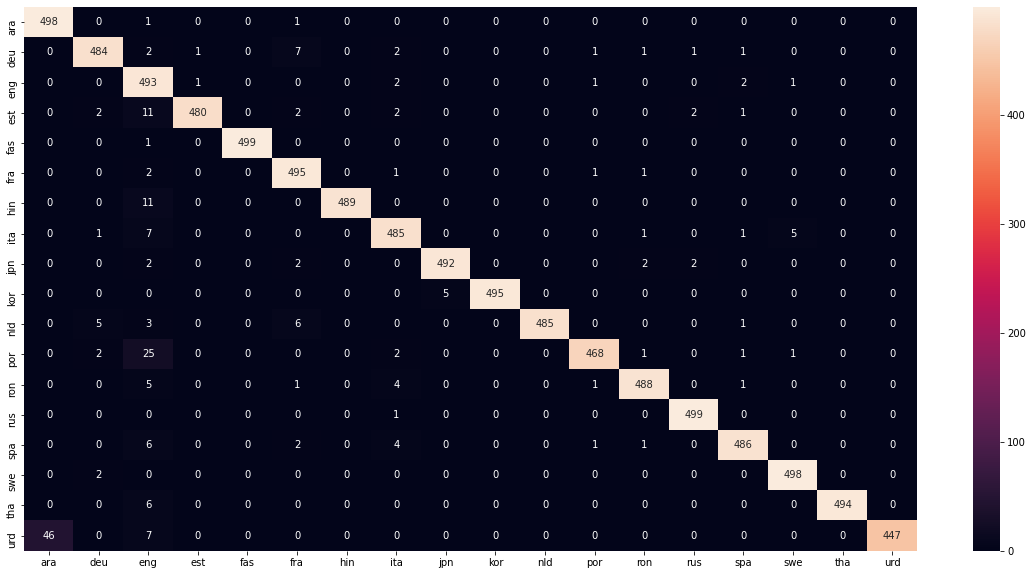

In [38]:
label_list = sorted(list(set(y_pred)))
cm = confusion_matrix(Y_test, y_pred, label_list)

plt.figure(figsize = (20, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_list, yticklabels=label_list)